<a href="https://colab.research.google.com/github/affert/demo_app/blob/master/goose_pytorch1_8_detectron2_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sign up for Sense Data Annotation: [http://sixgill.tech/ai-powered-labeling](http://sixgill.tech/ai-powered-labeling)

# Welcome to Google Colab

Colab is essentially Google's way of hosting a [jupyter notebook](https://jupyter.org/). A very popular tool to use as a data scientist!

It allows us to write code, documentation, and output visuals all in one place.

To be able to and edit the code in this workshop. Please make a copy for yourself

`file > save a copy in drive`

This should open a new tab with your own copy of this notebook. It can take a minute to load.

Colab comes with a lot of great data science libraries pre-installed. We'll show to start working with them in part-2 

Colab also gives you some options for running complicated computations such as training deep learning model. To see access those options:

`Runtime > change runtime type` Select `GPU`, `TPU`, or `None`

We don't need to change anything for this workshop, but its a great resource if you start learning deep learning and don't have a powerful GPU at home. 

This is a text cell. 

You can add a new text cell by clicking `+ Text` above. 

It does not highlight wrong spelling. I apologize for any typos!


### Code Cells

Below is a code cell. There is nothing in it right now.

To run a code cell click on it and then click the play button. Or press `shift+enter`

You can add new code cells by clicking the ` + Code ` button above



In [ ]:
print("Hello world!")

### Run Terminal Commands

Colab actually gives you access to a whole ubuntu instance!

You can run terminal commands by putting `!` before the command

In [ ]:
!ls

sample_data


# Install Detectron2 and Dependencies

In [ ]:
# Install torch 1.8 for detectron2 ( if colab  changes versions)

!pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

In [ ]:
torch.__version__

'1.8.1+cu101'

In [ ]:
torchvision.__version__

'0.9.1+cu101'

In [ ]:
# # install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

In [ ]:
# Make sure compatible pillow version
!pip install pillow==7.2
# %reload_ext autoreload
# %autoreload

In [ ]:
# Some basic setup:
# Import detectron2 & common detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

import tqdm
import time

# Creating a Dataset

[Sign Up](http://sixgill.tech/ai-powered-labeling) for Sense Data Annotation. No card required.

Labeled with [Sense Data Annotation](https://sixgill.com/platform/sense-data-annotation/) and exported in the COCO format.

Read Sense Data Annotation docs [here](https://docs.sixgill.com/).

Give me any feedback / ask questions on [slack](https://sixgill.tech/slack)

![Labeling for object detection](https://gblobscdn.gitbook.com/assets%2F-MJxxV6sKASlEjxiEwc2%2F-MKrhpy2wLI2lxD79AhV%2F-MKrinYxj-fQSlHaP6jB%2FSmartPoly_2cows.gif?alt=media&token=667d94a8-2493-4e5c-846c-0bae50480ba4)




# Download our already labeled Dataset

For this project we're going to use my "famous" synthetic goose dataset. Read more about how and why that was created here: https://github.com/sagecodes/make-a-wildlife-object-detector

In [ ]:
# download dataset from github
!git clone https://github.com/sagecodes/geese-object-detection-dataset.git


In [ ]:
!ls geese-object-detection-dataset

In [ ]:
!ls geese-object-detection-dataset/img

## Import a Dataset

### Setup COCO dataset for detectron2

[Detectron2 dataset docs](https://detectron2.readthedocs.io/tutorials/datasets.html)

[COCO](https://cocodataset.org/#home) is a popular dataset and computer vision dataset format




For this workshop we're using git clone, but for your own data you can use a couple other ways

- directly upload to colab instance
- mount to google drive <-- strongly encouraged for long term projects 

<-- You can easily to do both from the side bar

or you can mount with a code cell
```
drive.mount('/content/gdrive')
```




In [ ]:
# import COCO format datasets
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/geese-object-detection-dataset/train.json", "/content/geese-object-detection-dataset")
register_coco_instances("my_dataset_val", {}, "/content/geese-object-detection-dataset/validation.json", "/content/geese-object-detection-dataset")

# bonus labled dataset for getting more metrics on our model
register_coco_instances("my_dataset_test", {}, "/content/geese-object-detection-dataset/test.json", "/content/geese-object-detection-dataset")


In [ ]:
# check dataset is reading correctly
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")

dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

# set meta data for validation set (we'll usue this later for testing)
test_metadata = MetadataCatalog.get("my_dataset_test")

You can learn more about this dataset [here](https://github.com/sagecodes/make-a-wildlife-object-detector)

In [ ]:
# Let look at what our dataset looks like after loading in
dataset_dicts

# Training a Detectron2 Model for Object Detection 

Setup Validation class

https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [ ]:
# Create class for doing validation during training
# Read more about this above: 

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR,"inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)


https://detectron2.readthedocs.io/tutorials/configs.html

model zoo: https://github.com/facebookresearch/Detectron/blob/master/MODEL_ZOO.md


**Some model types to try**

- Instance Segmentation: `COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml`
- Object Detection: `COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml` 


The warning: `Skip loading parameter 'roi_heads.box_predictor.cls_score.weight to the model due to incompatible shapes` is OK. It's because we have different number of classes than what the weights were trained on (81 clasess)

In [ ]:
from detectron2.engine import DefaultTrainer

# initialize Detectron2 Training configuration
cfg = get_cfg()
# Select Model from Model Zoo 
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# Let training initialize from pretrained model zoo weights (transfer learning!)
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
# Select how many classes you're training to detect
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# Pass in training dataset (don't forget comma at end)
cfg.DATASETS.TRAIN = ("my_dataset_train",)
# Number of iteration to learn from our dataset
cfg.SOLVER.MAX_ITER = 300
# Learning Rate (think: how your network adjusts weights)
cfg.SOLVER.BASE_LR = 0.001
# Can adjust for Multi processes loading
cfg.DATALOADER.NUM_WORKERS = 0
# Images per batch per GPU
cfg.SOLVER.IMS_PER_BATCH = 2
# Number of instances per btach
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32

# Create output directory for training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Load validation dataset
cfg.DATASETS.TEST = ("my_dataset_val",)
# number of iteration before validation
cfg.TEST.EVAL_PERIOD = 50

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

# Use a Trained Model

In [ ]:
!ls ./output/

In [ ]:
# Initialize config
cfg = get_cfg()
# Must be same as model trained in.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
# Path to saved model weights (trained model)
cfg.MODEL.WEIGHTS = '/content/output/model_final.pth'
# if using datasets for metadata
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
# Threshhold to show predictions
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
# create predictor instance to use
predictor = DefaultPredictor(cfg)

In [ ]:
# Run test on an image
# from detectron2.utils.visualizer import ColorMode
test_image_path = '/content/geese-object-detection-dataset/img/01ES4X7WSQF4XAGHFFACJSPN4Q.jpeg'
im = cv2.imread(test_image_path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.5
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# What does an image look like to the computer?
print(im)

In [ ]:
#What does the model output look like not drawn on an image?
print(outputs["instances"].to("cpu"))

In [ ]:
# Count objects detected in an image
object_count = outputs["instances"].to("cpu")
print("Detected "+str(len(object_count))+" Geese")

In [ ]:
# Run test on an image
# from detectron2.utils.visualizer import ColorMode
test_image_path = '/content/geese-object-detection-dataset/img/01ES4X8G607FY4FP9FV0E3WNNA.png'
im = cv2.imread(test_image_path)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.5
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

### Evaluation metrics

Here is great post that will go deeper into object detection evaluations metrics:

https://cocodataset.org/#detection-eval 

https://www.pyimagesearch.com/2018/05/14/a-gentle-guide-to-deep-learning-object-detection/

Detectron2 has built evaluation methods 

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

# Run detection on a video

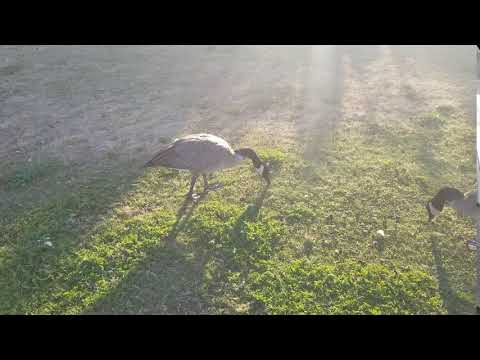

In [ ]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("6vmlPXkkQ4Y", width=500)
display(video)

In [ ]:
# Install dependencies, to download video, and crop for processing 
# Can skip if you are uploading your own video from google drive
!pip install youtube-dl
# !pip uninstall -y opencv-python-headless opencv-contrib-python
# !apt install python3-opencv  # the one pre-installed have some issues

In [ ]:
# Download video from youtube
!youtube-dl https://www.youtube.com/watch?v=6vmlPXkkQ4Y -f 22 -o video.mp4

In [ ]:
# (optional) create clip from video. Useful for large videos
!ffmpeg -i /content/video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [ ]:
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode#, Visualizer

# Extract video properties
video = cv2.VideoCapture('/content/video.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter('out.mp4',
                               fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
                               fps=float(frames_per_second),
                               frameSize=(width, height),
                               isColor=True)

# Initialize visualizer
v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TEST[0]),
                                        ColorMode.IMAGE)

def run_model_on_video(video, maxFrames):
    """ 
    Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """

    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame,
                                                    outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(),
                                     cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

# Enumerate the frames of the video
for visualization in tqdm.tqdm(run_model_on_video(video, num_frames),
                               total=num_frames):

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()

In [ ]:
# Download the results
from google.colab import files
files.download('out.mp4')

# Keep Learning!

We just scratched the surface of the computer vision field, but I hope you feel confidant and inspired to learn more about it and creat your own projects! 

[Sign up for Sense Data Annotation](http://sixgill.tech/ai-powered-labeling) & Start Labeling your own datasets! Retrain this notebook with them.

[Join me in slack](https://bit.ly/30lO9Cq) to ask any questions.

Follow Sixgill on [Medium](https://medium.com/sixgill) for Computer Vision Tutorials

Subscribe on [youtube](https://www.youtube.com/channel/UCWt--5NcY-O9PhjfPSDotew) for more content around computer vision.

Read/watch [my talk](https://github.com/sagecodes/make-a-wildlife-object-detector) on how to think about data and create sythetic data to improve your models.


### Learn more about different object detection methods:


- Single Shot MultiBox Detector (SSD) [explained](https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab) | [paper](https://arxiv.org/abs/1512.02325)

- You Only Look Once (YOLO) [Explained](https://medium.com/@jonathan_hui/real-time-object-detection-with-yolo-yolov2-28b1b93e2088) | [Paper](https://arxiv.org/abs/1506.02640) 

- Mask R-CNN [Explained](https://medium.com/@jonathan_hui/image-segmentation-with-mask-r-cnn-ebe6d793272) | [Paper](https://arxiv.org/abs/1703.06870)

- Detectron2 [github](https://github.com/facebookresearch/detectron2) | [official coloab](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)

[Pyimagesearch](https://www.pyimagesearch.com/category/object-detection/) and [Machine Learning Mastery](https://machinelearningmastery.com/) are a great resources to take a look at. 


-------------------

#### Raw Links for chat:
http://sixgill.tech/ai-powered-labeling

https://www.linkedin.com/in/sageelliott/

https://twitter.com/sagecodes

https://github.com/sagecodes

https://medium.com/sixgill

https://github.com/sagecodes/make-a-wildlife-object-detector

https://sixgill.tech/slack


